## GAN

|Discriminant|Generative|
|-|-|
|linear|non-linear|
|porbabilistic|stochastic|
|parametric|non-parametric|
|black box|whtie box|

- feedback을 받아가면서 실제 물체와 비슷하게 만듬
    - 실제 특성이 거절당할 때마다 배움
- **적대적 관계에서 숨어 있는 분포를 찾아 이것을 기반으로 생성**
    < - > autoencoder : 비교를 하면서
    
- 실제로 사람이 배우는 방식과 비슷

**Network**
- 순수한 머신러닝을 기법을 쓴다는 것을 암시 ( 옛날에 model이 아닌 network라 부름)

</br>

- 생성은 할 수 있지만 학습이 잘 안됨


---

## 학습 테크닉

**overfitting**
- 데이터 확보
    - noisy 생성
- 데이터 전처리
- 모델 단순화
    - feature 줄이기(filer, wrapper, embeded)
    - 차원 축소(feature를 변형)
- 앙상블
    - dropout
- regularizer : 모델 복잡하지 않게
- early stopping


**underfitting**
- relu, leaky relu
- normalization
    - BN
    - layer
    - instance
    - weight
- initializer
- optimizer
- gradient clipping
- learning rate decay


DCGAN(Deep Convolution GAN)

GAN은 간단한 예시 외에 fit을 쓰지 않음!

https://www.tensorflow.org/tutorials/generative/dcgan

미술관에 간 GAN 프로젝트

http://introtodeeplearning.com/  : MIT 강의

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
(x_train,y_train),(_,_) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = (x_train - 127.5)/127.5
# [-1, 1]로 정규화 -> 값이 양수, 음수 -> zero centered

In [4]:
BATCH_SIZE = 256

train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(BATCH_SIZE)

### Generative

- 숨어 있는 분포 찾기
- 분포를 받아서 Convolution해서 생성

### Leaky relu
- 음수에서 0에 가까운 기울기를 만들어 0값을 안 가지도록 하는 것

### 학습전략
- BN
- Conv2DTranspose
- fiter size : vgg 3,5
- stride로 pooling 대신 씀
- padding same

In [5]:
NOISY_DIM = 100

def make_generative_model():
    generative_model = tf.keras.models.Sequential([
        # bias 굳이 필요없음
        tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(NOISY_DIM ,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Reshape((7, 7, 256)),
        tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=2, padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        # 출력 하나로
        tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=2, padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
    ])
    return generative_model

# 예시에서는 assert를 하기 위해 add하는 식으로 만듬

In [6]:
generative = make_generative_model()
generative(tf.random.normal([1,100])).shape

TensorShape([1, 28, 28, 1])

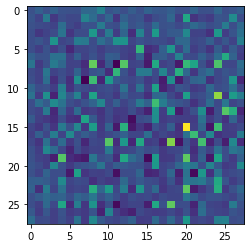

In [7]:
# 학습 안된 결과
img = generative(tf.random.normal([1,100]))
img = img.numpy().reshape(28,28)

plt.imshow(img)

In [8]:
def make_discriminator_model():
    discriminator = tf.keras.models.Sequential([
        # 모델이 단순화 됨
        tf.keras.layers.Conv2D(64, (5, 5), input_shape=(28,28,1)),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
# activation 다음 dropout
        
        tf.keras.layers.Conv2D(128, (5, 5), strides=2),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1),
    ])
    return discriminator

In [9]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 64)        1664      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 128)       204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 10, 10, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)            

### loss
- 위에서 sigmoid를 하지 않았음 -> from_logits

from_logit : numerically stable (학습 안 될 때)

진짜와 가짜 데이터 판별하는 능력 둘 다 기르기 -> loss 두 개 (**multi task loss**)


#### compile에서 loss
- 문자열
- 소문자(객체) : 상속 재활용, callable(함수)
- 대문자

In [10]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def discriminator_loss(real, fake):
    real_loss = loss(tf.ones_like(real),real)
    fake_loss = loss(tf.ones_like(fake),fake)
    losss = real_loss + fake_loss
    return losss

In [12]:
def generative_loss(fake):
    return loss(tf.ones_like(fake),fake)

In [27]:
import inspect
print(inspect.getsource(discriminator.__call__))

# training option : False로 주면 학습을 안함.

  def __call__(self, *args, **kwargs):
    """Wraps `call`, applying pre- and post-processing steps.

    Arguments:
      *args: Positional arguments to be passed to `self.call`.
      **kwargs: Keyword arguments to be passed to `self.call`.

    Returns:
      Output tensor(s).

    Note:
      - The following optional keyword arguments are reserved for specific uses:
        * `training`: Boolean scalar tensor of Python boolean indicating
          whether the `call` is meant for training or inference.
        * `mask`: Boolean input mask.
      - If the layer's `call` method takes a `mask` argument (as some Keras
        layers do), its default value will be set to the mask generated
        for `inputs` by the previous layer (if `input` did come from
        a layer that generated a corresponding mask, i.e. if it came from
        a Keras layer with masking support.

    Raises:
      ValueError: if the layer's `call` method returns None (an invalid value).
      RuntimeError: if 

In [13]:
optimizer_g = tf.keras.optimizers.Adam(1e-4)
optimizer_d = tf.keras.optimizers.Adam(1e-4)

In [15]:
# 동시에 학습
@tf.function
def train_step(real):
    
    with tf.GradientTape() as ge, tf.GradientTape() as d:
        imgs = generative(noise,training=True)
        real_img = discriminator(real,training = True)
        fake_img = discriminator(imgs,training = True)
        # 어제는 gene가 false, dis가 true 였음

        # loss 정의 후 graienttape 학습
        gen_loss = generative_loss(fake_img)
        dis_loss = discriminator_loss(real_img, fake_img)

    # loss를 variables에 관해 미분
    gd = ge.gradient(gen_loss, generative.trainable_variables)
    dd = d.gradient(dis_loss, discriminator.trainable_variables)

    optimizer_g.apply_gradients(zip(gd, generative.trainable_variables))
    optimizer_d.apply_gradients(zip(dd, discriminator.trainable_variables))

In [14]:
noise = tf.random.normal([BATCH_SIZE, NOISY_DIM])
real = x_train

- fit:epoch 별
- train_on_batch :batch만큼
- GradientTape: for 이용해서 epoch별 batch size만큼

<br>

training : 번갈아 학습 가능하도록(True,False)

autoencoder : 실제 분포가 있지만 노이즈 있으면 가짜 데이터, 학습을 통해서 노이즈 제거해서 실제분포 찾음
- 노이즈 데이터와 실제데이터 비교해서 노이즈 제거
- 노이즈 데이터로 실제값을 받으면 생성 학습을 통해서 노이즈 제거해서 실제 분포 찾아서 값 정확하게 예측 가능

In [16]:
for k in range(5):
    for i in train:
        train_step(i)
        
# generative가 공부

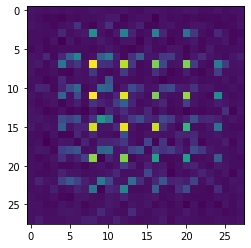

In [17]:
img = generative(tf.random.normal([1,100]))
img = img.numpy().reshape(28,28)

plt.imshow(img)

예시처럼 trainable을 바꿔주는 작업 필요
50번은 해야된다 함....